## Import

In [ ]:
import numpy as np
import random
import os
import math

from glob import glob
import pandas as pd
import cv2
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
from torchvision import transforms

: 

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

: 

## Hyperparameters Setting

In [141]:
CFG = {
    'IMG_SIZE':128,
    'EPOCHS':10,
    'LEARNING_RATE':2e-3,
    'BATCH_SIZE':32,
    'SEED':41
}

## Fix RandomSeed

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED']) # Seed 고정

## Data Pre-processing

In [11]:
def get_train_data(data_dir):
    img_path_list = []
    label_list = []
    for case_name in os.listdir(data_dir):
        current_path = os.path.join(data_dir, case_name)
        if os.path.isdir(current_path):
            # get image path
            img_path_list.extend(glob(os.path.join(current_path, 'image', '*.jpg')))
            img_path_list.extend(glob(os.path.join(current_path, 'image', '*.png')))
            
            # get label
            label_df = pd.read_csv(current_path+'/label.csv')
            label_list.extend(label_df['leaf_weight'])
                
    return img_path_list, label_list

def get_test_data(data_dir):
    # get image path
    img_path_list = glob(os.path.join(data_dir, 'image', '*.jpg'))
    img_path_list.extend(glob(os.path.join(data_dir, 'image', '*.png')))
    img_path_list.sort(key=lambda x:int(x.split('\\')[-1].split('.')[0]))
    return img_path_list

In [12]:
all_img_path, all_label = get_train_data('./dataset/train')
test_img_path = get_test_data('./dataset/test')

## Train / Validation Split

In [13]:
# Train : Validation = 0.8 : 0.2 Split
train_len = int(len(all_img_path)*0.8)

train_img_path = all_img_path[:train_len]
train_label = all_label[:train_len]

vali_img_path = all_img_path[train_len:]
vali_label = all_label[train_len:]

## CustomDataset

In [7]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, train_mode=True, transforms=None):
        self.transforms = transforms
        self.train_mode = train_mode
        self.img_path_list = img_path_list
        self.label_list = label_list

    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        # Get image data
        image = cv2.imread(img_path)
        if self.transforms is not None:
            image = self.transforms(image)

        if self.train_mode:
            label = self.label_list[index]
            return image, label
        else:
            return image
    
    def __len__(self):
        return len(self.img_path_list)

In [8]:
train_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                    ])

test_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize((CFG['IMG_SIZE'], CFG['IMG_SIZE'])),
                    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
                    ])

In [13]:
len(all_img_path), len(test_img_path)

(1592, 460)

In [72]:
train_transform(cv2.imread(all_img_path[0])).transpose(0,1).transpose(1,2).shape

torch.Size([128, 128, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


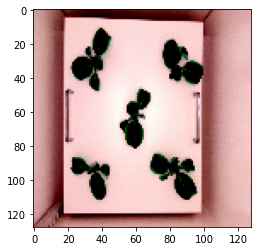

In [73]:
# from PIL import Image
# PIL_image = Image.fromarray(ndarray_image)
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(train_transform(cv2.imread(all_img_path[0])).transpose(0,1).transpose(1,2))

In [16]:
# Get Dataloader
train_dataset = CustomDataset(train_img_path, train_label, train_mode=True, transforms=train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

vali_dataset = CustomDataset(vali_img_path, vali_label, train_mode=True, transforms=test_transform)
vali_loader = DataLoader(vali_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

test_dataset = CustomDataset(test_img_path, None, train_mode=False, transforms=test_transform)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [289]:
all_meta_path = glob.glob(os.path.join('dataset_128', 'train', 'CASE*', 'meta', '*.csv'))
test_meta_path = glob.glob(os.path.join('dataset_128', 'test', 'meta', '*.csv'))

In [318]:
from sklearn.preprocessing import MinMaxScaler
train_scaler = MinMaxScaler(feature_range=(-1,1))
test_scaler = MinMaxScaler(feature_range=(-1,1))

In [319]:
train_val_meta = [train_scaler.fit_transform(torch.Tensor(pd.read_csv(i)[['내부온도관측치', '외부온도관측치', '내부습도관측치', '외부습도관측치', 'CO2관측치', 'EC관측치',
       '최근분무량', '화이트 LED동작강도', '레드 LED동작강도', '블루 LED동작강도', '냉방온도', '냉방부하',
       '난방온도', '난방부하', '총추정광량', '백색광추정광량', '적색광추정광량', '청색광추정광량']].fillna(method='bfill').fillna(0).to_numpy().flatten().astype('float32')).reshape(1,-1)).squeeze(0) for i in all_meta_path]

In [320]:

test_meta = [test_scaler.fit_transform(torch.Tensor(pd.read_csv(i)[['내부온도관측치', '외부온도관측치', '내부습도관측치', '외부습도관측치', 'CO2관측치', 'EC관측치',
       '최근분무량', '화이트 LED동작강도', '레드 LED동작강도', '블루 LED동작강도', '냉방온도', '냉방부하',
       '난방온도', '난방부하', '총추정광량', '백색광추정광량', '적색광추정광량', '청색광추정광량']].fillna(method='bfill').fillna(0).to_numpy().flatten().astype('float32')).reshape(1,-1)).squeeze(0) for i in test_meta_path]

In [321]:
train_meta = train_val_meta[:train_len]
val_meta = train_val_meta[train_len:]

In [322]:
train_meta_loader = DataLoader(train_meta, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)     #random seed 고정
val_meta_loader = DataLoader(val_meta, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)     #random seed 고정


In [323]:
test_meta_loader = DataLoader(test_meta, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)     #random seed 고정

['시간', '내부온도관측치', '외부온도관측치', '내부습도관측치', '외부습도관측치', 'CO2관측치', 'EC관측치',
       '최근분무량', '화이트 LED동작강도', '레드 LED동작강도', '블루 LED동작강도', '냉방온도', '냉방부하',
       '난방온도', '난방부하', '총추정광량', '백색광추정광량', '적색광추정광량', '청색광추정광량']

total_dataset = CustomDataset(all_img_path, all_label, train_mode=True, transforms=train_transform)

from torchvision.utils import save_image

all_img_path[0][:9] + '_128' + all_img_path[0][9:]

total_dataset[0]

for name,img in zip(all_img_path, total_dataset):
    save_image(img[0], name[:9] + '_128' + name[9:])

import matplotlib.pyplot as plt

%matplotlib inline
plt.imshow(img[0])

all_img_path

import glob

label_folder = glob.glob(os.path.join('dataset', 'train', 'CASE*', '*.csv'))

meta_data = glob.glob(os.path.join('dataset', 'train', 'CASE*', 'meta', '*.csv'))

for csv in label_folder:
    temp = pd.read_csv(csv)
    print(temp)
    temp.to_csv(csv[:7]+'_128'+csv[7:])

for csv in meta_data:
    temp = pd.read_csv(csv)
    temp.to_csv(csv[:7]+'_128'+csv[7:])

for name,img in zip(test_img_path, test_dataset):
    save_image(img, name[:9] + '_128' + name[9:])
    
    


## Define Model Architecture

class CNNRegressor(torch.nn.Module):
    def __init__(self):
        super(CNNRegressor, self).__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer4 = torch.nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        #! meta data 관련 정보 추가
        
        self.regressor = nn.Linear(3136,1)          #!3136에 추가되서 예측


    def forward(self, x):
        # Simple CNN Model (Batch, 3, 128, 128 -> Batch, 64, 7, 7)
        # (Batch, 3, 128, 128)
        x = self.layer1(x)
        # (Batch, 8, 64, 64)
        x = self.layer2(x)
        # (Batch, 16, 32, 32)
        x = self.layer3(x)
        # (Batch, 32, 16, 16)
        x = self.layer4(x)
        # (Batch, 64, 7, 7) -> Flatten (Batch, 64*7*7(=3136))
        x = torch.flatten(x, start_dim=1)
        # Regressor (Batch, 3136) -> (Batch, 1)
        out = self.regressor(x)
        return out

In [328]:
class CNNTABRegressor(torch.nn.Module):
    def __init__(self):
        super(CNNTABRegressor, self).__init__()
        self.layer1 = torch.nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer2 = torch.nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer3 = torch.nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.layer4 = torch.nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=4, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        
        self.meta = torch.nn.Sequential(
            nn.Linear(25920, 2048),
            nn.Linear(2048, 512),
            nn.Linear(512, 32)
        )
        
        
        #! meta data 관련 정보 추가
        
        self.regressor = nn.Linear(3136+32,1)          #!3136에 추가되서 예측


    def forward(self, x, m):
        # Simple CNN Model (Batch, 3, 128, 128 -> Batch, 64, 7, 7)
        # (Batch, 3, 128, 128)
        x = self.layer1(x)
        # (Batch, 8, 64, 64)
        x = self.layer2(x)
        # (Batch, 16, 32, 32)
        x = self.layer3(x)
        # (Batch, 32, 16, 16)
        x = self.layer4(x)
        # (Batch, 64, 7, 7) -> Flatten (Batch, 64*7*7(=3136))
        x = torch.flatten(x, start_dim=1)
        # Regressor (Batch, 3136) -> (Batch, 1)
        
        m = self.meta(m)
        print("x size : ", x.size())
        print("m size : ", m.size())
        
        x = torch.cat((x, m), dim=1)
        print("cat size : ", x.size())
        
        out = self.regressor(x)
        print(out)
        
        return out

## Train

def train(model, optimizer, train_loader, vali_loader, scheduler, device):
    model.to(device)

    # Loss Function
    criterion = nn.L1Loss().to(device)
    best_mae = 9999
    
    for epoch in range(1,CFG["EPOCHS"]+1):
        model.train()
        train_loss = []
        for img, label in tqdm(iter(train_loader)):
            img, label = img.float().to(device), label.float().to(device)
            
            optimizer.zero_grad()

            # Data -> Model -> Output
            logit = model(img)
            # Calc loss
            loss = criterion(logit.squeeze(1), label)

            # backpropagation
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            
        if scheduler is not None:
            scheduler.step()
            
        # Evaluation Validation set
        vali_mae = validation(model, vali_loader, criterion, device)
        
        print(f'Epoch [{epoch}] Train MAE : [{np.mean(train_loss):.5f}] Validation MAE : [{vali_mae:.5f}]\n')
        
        # Model Saved
        if best_mae > vali_mae:
            best_mae = vali_mae
            torch.save(model.state_dict(), './saved/best_model.pth')
            print('Model Saved.')

In [329]:
def train(model, optimizer, train_loader, vali_loader, scheduler, device):
    model.to(device)

    # Loss Function
    criterion = nn.MSELoss().to(device)
    best_mae = 9999
    
    for epoch in range(1,CFG["EPOCHS"]+1):
        print(epoch)
        model.train()
        train_loss = []
        meta_loader = [i for i in enumerate(train_meta_loader)]
        for idx, data in enumerate(train_loader):
            print(idx)
            img, label = data[0], data[1]
            # meta = train_meta_loader[idx]
            meta = meta_loader[idx][1]
            img, label = img.float().to(device), label.float().to(device)
            meta = meta.float().to(device)
            
            optimizer.zero_grad()

            # Data -> Model -> Output
            print("model start")
            logit = model(img, meta)
            print("model end")
            # Calc loss
            loss = criterion(logit.squeeze(1), label)

            # backpropagation
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            
        if scheduler is not None:
            scheduler.step()
            
        # Evaluation Validation set
        vali_mae = validation(model, vali_loader, criterion, device)
        
        print(f'Epoch [{epoch}] Train MAE : [{np.mean(train_loss):.5f}] Validation MAE : [{vali_mae:.5f}]\n')
        
        # Model Saved
        if best_mae > vali_mae:
            best_mae = vali_mae
            torch.save(model.state_dict(), './saved/best_model.pth')
            print('Model Saved.')

In [330]:
def validation(model, vali_loader, criterion, device):
    model.eval() # Evaluation
    vali_loss = []
    with torch.no_grad():
        meta_loader = [i for i in enumerate(val_meta_loader)]
        for idx, data in enumerate(vali_loader):
            img, label = data[0], data[1]
            # meta = val_meta_loader[idx]
            meta = meta_loader[idx][1]
            img, label = img.float().to(device), label.float().to(device)
            meta = meta.float().to(device)
            
            logit = model(img, meta)
            loss = criterion(logit.squeeze(1), label)
            
            vali_loss.append(loss.item())

    vali_mae_loss = np.mean(vali_loss)
    return vali_mae_loss  

## Run!!

In [ ]:
print(torch.cuda.is_available())

In [331]:
model = CNNTABRegressor().to(device)

optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = None

train(model, optimizer, train_loader, vali_loader, scheduler, device)

1
0
model start
x size :  torch.Size([32, 3136])
m size :  torch.Size([32, 32])
cat size :  torch.Size([32, 3168])
tensor([[0.0252],
        [0.0222],
        [0.0231],
        [0.0240],
        [0.0365],
        [0.0267],
        [0.0386],
        [0.0282],
        [0.0275],
        [0.0313],
        [0.0283],
        [0.0245],
        [0.0259],
        [0.0251],
        [0.0217],
        [0.0223],
        [0.0275],
        [0.0292],
        [0.0245],
        [0.0315],
        [0.0254],
        [0.0261],
        [0.0233],
        [0.0233],
        [0.0284],
        [0.0332],
        [0.0269],
        [0.0252],
        [0.0274],
        [0.0244],
        [0.0188],
        [0.0228]], device='cuda:0', grad_fn=<AddmmBackward>)
model end
1
model start
x size :  torch.Size([32, 3136])
m size :  torch.Size([32, 32])
cat size :  torch.Size([32, 3168])
tensor([[45.9311],
        [45.9659],
        [45.9649],
        [45.9486],
        [45.9237],
        [45.9532],
        [45.9729],
        [4

Sizes of tensors must match except in dimension 0. Got 32 and 31 (The offending index is 0)

## Inference

In [ ]:
def predict(model, test_loader, test_meta_loader, device):
    model.eval()
    model_pred = []
    with torch.no_grad():
        meta_loader = [i for i in enumerate(test_meta_loader)]
        for idx, data in enumerate(test_loader):
            img = data[0]
            # meta = val_meta_loader[idx]
            meta = meta_loader[idx][1]
            img = img.float().to(device)
            meta = meta.float().to(device)

            pred_logit = model(img, meta)
            pred_logit = pred_logit.squeeze(1).detach().cpu()

            model_pred.extend(pred_logit.tolist())
    return model_pred

In [ ]:
test_dataset = CustomDataset(test_img_path, None, train_mode=False, transforms=test_transform)
test_loader = DataLoader(test_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

# Validation Score가 가장 뛰어난 모델을 불러옵니다.
checkpoint = torch.load('./saved/best_model.pth')
model = CNNTABRegressor().to(device)
model.load_state_dict(checkpoint)

# Inference
preds = predict(model, test_loader, test_meta_loader, device)

RuntimeError: Error(s) in loading state_dict for CNNTABRegressor:
	Missing key(s) in state_dict: "meta.0.weight", "meta.0.bias", "meta.1.weight", "meta.1.bias". 
	size mismatch for regressor.weight: copying a param with shape torch.Size([1, 3136]) from checkpoint, the shape in current model is torch.Size([1, 3648]).

## Submission

In [ ]:
preds

[58.58141326904297,
 143.59283447265625,
 -1.6936466693878174,
 55.583518981933594,
 65.65078735351562,
 61.60427474975586,
 -4.425544738769531,
 61.53095245361328,
 -1.798891544342041,
 67.88890838623047,
 -4.905154705047607,
 36.50437927246094,
 0.9731063842773438,
 36.09989547729492,
 -1.0720853805541992,
 61.85447311401367,
 61.105892181396484,
 40.899227142333984,
 64.83512878417969,
 138.255859375,
 46.81692123413086,
 -1.8089978694915771,
 -3.7091383934020996,
 -47.19990539550781,
 60.41492462158203,
 40.799072265625,
 94.99515533447266,
 51.88534927368164,
 61.219261169433594,
 67.640625,
 54.04057312011719,
 8.783977508544922,
 -3.8464059829711914,
 -1.1856470108032227,
 5.617023468017578,
 115.60542297363281,
 -3.015195369720459,
 67.87104034423828,
 -0.763853132724762,
 44.2213134765625,
 62.03602981567383,
 58.70888900756836,
 -2.0447425842285156,
 29.92577362060547,
 62.877384185791016,
 27.742185592651367,
 62.270790100097656,
 43.147220611572266,
 -17.81831932067871,
 47

In [ ]:
submission = pd.read_csv('./sample_submission.csv')
submission['leaf_weight'] = preds
submission.to_csv('./submit_22042501.csv', index=False)

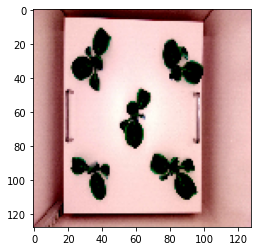

In [6]:
route = "./dataset_128/train/CASE01/image/CASE01_01.png"
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
plt.imshow(mpimg.imread(route))

In [9]:
from PIL import Image
from torchvision import transforms

img = Image.open("./dataset_128/train/CASE01/image/CASE01_01.png")
transform = transforms.ToTensor()
transform(img).shape

torch.Size([3, 128, 128])

In [11]:
import torch
imgTensor = torch.Tensor()

In [18]:
import glob
from PIL import Image

In [19]:
trainpath = glob.glob(os.path.join('.', 'dataset_128', 'train', 'CASE*', 'image', '*'))
traintensor = torch.Tensor(size=[0,3,128,128])
for index, i in enumerate(trainpath):
    img = Image.open(i)
    transform = transforms.ToTensor()
    temp = transform(img)
    temp = temp.unsqueeze(dim=0)
    # traintensor.cat(temp)
    traintensor = torch.cat([traintensor, temp],dim = 0)
    if index%100==0:
        print(1)
traintensor.shape


1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1


torch.Size([1592, 3, 128, 128])

In [20]:
from augmentation import *
import random
import time
def augment(traintensor):
    augmenttraintensor = torch.Tensor(size = [0,3,128,128])
    for index, image in enumerate(traintensor):
        start = time.time()
        rand = random.random()
        #image = image.unsqueeze(dim = 0)
        #print(image.shape)
        if rand<0.33:
            temp_1 = iso_scaling(image)
            temp_2 = gau_blur(image)
            temp_1 = temp_1.unsqueeze(dim = 0)
            temp_2 = temp_2.unsqueeze(dim = 0)
        elif rand<0.67 and rand>=0.33:
            temp_1 = rand_erasing(image)
            temp_2 = gau_noise(image)
            temp_1 = temp_1.unsqueeze(dim = 0)
            temp_2 = temp_2.unsqueeze(dim = 0)
        else:
            temp_1 = salt_pepper(image)
            temp_2 = hue_rotation(image)
            temp_1 = temp_1.unsqueeze(dim = 0)
            temp_2 = temp_2.unsqueeze(dim = 0)
        image = image.unsqueeze(dim = 0)
        augmenttraintensor = torch.cat([augmenttraintensor, temp_1],dim=0)
        augmenttraintensor = torch.cat([augmenttraintensor, temp_2],dim=0)
        augmenttraintensor = torch.cat([augmenttraintensor, image],dim=0)
        if index%100==0:
            print("------", index)
            print(time.time() - start)
    return augmenttraintensor

In [21]:
traintensor1 = traintensor[:400]
traintensor2 = traintensor[400:800]
traintensor3 = traintensor[800:1200]
traintensor4 = traintensor[1200:]
traintensor_all = torch.Tensor(size = [0,3,128,128])
traintensor_all = torch.cat([traintensor_all, augment(traintensor1)], dim = 0)
print("&&&&&")
traintensor_all = torch.cat([traintensor_all, augment(traintensor2)], dim = 0)
print("&&&&&")
traintensor_all = torch.cat([traintensor_all, augment(traintensor3)], dim = 0)
print("&&&&&")
traintensor_all = torch.cat([traintensor_all, augment(traintensor4)], dim = 0)
print(traintensor_all.shape)

------ 0
0.00997304916381836
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([3, 128, 128])
torch.Siz

In [22]:
traintensor_all.shape

torch.Size([4776, 3, 128, 128])

In [23]:
len(train_label)+len(vali_label)
train_all_label_1 = train_label+vali_label
train_all_label = []
for i in train_all_label_1:
    train_all_label.append(i)
    train_all_label.append(i)
    train_all_label.append(i)
len(train_all_label)
    

4776

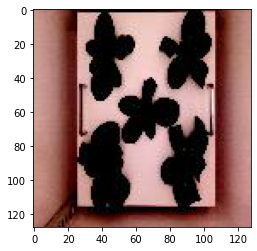

In [169]:
plt.imshow(traintensor_all[1001].squeeze(0).permute(1,2,0))

traintensor_all 과 train_all_label 이게  augmentation 시킨 traintensor 이미지와 라벨임

In [25]:
trainimage_tensor = traintensor_all[:1250]
trainlabel = train_all_label[:1250]
trainlabel = torch.Tensor(trainlabel)
validimage_tensor = traintensor_all[1250:]
validlabel = train_all_label[1250:]
validlabel = torch.Tensor(validlabel)

In [26]:
torch.save(trainimage_tensor, "./imagepreprocessdataset/trainimagetensor.pt")
torch.save(trainlabel, "./imagepreprocessdataset/trainlabel.pt")
torch.save(validimage_tensor, "./imagepreprocessdataset/validimagetensor.pt")
torch.save(validlabel, "./imagepreprocessdataset/validlabel.pt")

In [ ]:
trainimage_tensor = torch.load("./imagepreprocessdataset/trainimagetensor.pt")
validimage_tensor = torch.load("./imagepreprocessdataset/validimagetensor.pt")
trainlabel = torch.load("./imagepreprocessdataset/trainlabel.pt")
validlabel = torch.load("./imagepreprocessdataset/validlabel.pt")

: 

In [30]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
class CustomDataset(Dataset): 
  def __init__(self, x, y):
    self.x_data = x
    self.y_data = y

  # 총 데이터의 개수를 리턴
  def __len__(self): 
    return len(self.x_data)

  # 인덱스를 입력받아 그에 맵핑되는 입출력 데이터를 파이토치의 Tensor 형태로 리턴
  def __getitem__(self, idx): 
    x = torch.FloatTensor(self.x_data[idx])
    y = torch.FloatTensor(self.y_data[idx])
    return x, y

In [72]:
trainlabel = trainlabel.unsqueeze(-1)
validlabel = validlabel.unsqueeze(-1)

In [73]:
train_dataset = CustomDataset(trainimage_tensor, trainlabel)
trainloader = DataLoader(train_dataset, batch_size=32, num_workers=0, shuffle=True)
valid_dataset = CustomDataset(validimage_tensor, validlabel)
validloader = DataLoader(valid_dataset, batch_size=32, num_workers=0, shuffle=True)

In [82]:
def train(model, optimizer, train_loader, vali_loader, scheduler, device):
    model.to(device)

    # Loss Function
    criterion = nn.MSELoss().to(device)
    best_mae = 9999
    
    for epoch in range(1,11):
        print(epoch)
        model.train()
        train_loss = []
        #meta_loader = [i for i in enumerate(train_meta_loader)]
        for idx, data in enumerate(train_loader):
            print(idx)
            #img, label = data[0], data[1]
            img, label = data[0], data[1]
            # meta = train_meta_loader[idx]
            #meta = meta_loader[idx][1]
            img, label = img.float().to(device), label.float().to(device)
            #meta = meta.float().to(device)
            
            optimizer.zero_grad()

            # Data -> Model -> Output
            print("model start")
            logit = model(img)
            print("model end")
            # Calc loss
            loss = criterion(logit.squeeze(1), label)

            # backpropagation
            loss.backward()
            optimizer.step()

            train_loss.append(loss.item())
            
        if scheduler is not None:
            scheduler.step()
            
        # Evaluation Validation set
        vali_mae = validation(model, vali_loader, criterion, device)
        
        print(f'Epoch [{epoch}] Train MAE : [{np.mean(train_loss):.5f}] Validation MAE : [{vali_mae:.5f}]\n')
        
        # Model Saved
        if best_mae > vali_mae:
            best_mae = vali_mae
            torch.save(model.state_dict(), './saved/best_model.pth')
            print('Model Saved.')

In [84]:
def validation(model, vali_loader, criterion, device):
    model.eval() # Evaluation
    vali_loss = []
    with torch.no_grad():
        #meta_loader = [i for i in enumerate(val_meta_loader)]
        for idx, data in enumerate(vali_loader):
            img, label = data[0], data[1]
            # meta = val_meta_loader[idx]
            #meta = meta_loader[idx][1]
            img, label = img.float().to(device), label.float().to(device)
            #meta = meta.float().to(device)
            
            logit = model(img)
            loss = criterion(logit.squeeze(1), label)
            
            vali_loss.append(loss.item())

    vali_mae_loss = np.mean(vali_loss)
    return vali_mae_loss  

In [33]:
from resnet import resnet34
import torch.optim as optim
model = resnet34().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [85]:
train(model, optimizer, trainloader, validloader, scheduler, device)

1
0
model start


RuntimeError: Expected 3-dimensional input for 3-dimensional weight [64, 3, 15], but got 4-dimensional input of size [32, 3, 128, 128] instead

In [81]:
for i in trainloader:
    print(i[0])
    print("----")
    print(i[1])
    break

tensor([[[[0.6392, 0.6353, 0.6353,  ..., 0.6902, 0.6863, 0.7216],
          [0.6549, 0.6510, 0.6275,  ..., 0.7059, 0.7098, 0.7137],
          [0.6392, 0.6549, 0.6314,  ..., 0.6941, 0.7020, 0.7255],
          ...,
          [0.6314, 0.6471, 0.6078,  ..., 0.7922, 0.8078, 0.7961],
          [0.6118, 0.6000, 0.6314,  ..., 0.8000, 0.7922, 0.7961],
          [0.6157, 0.6039, 0.6000,  ..., 0.7804, 0.7686, 0.7843]],

         [[0.4980, 0.5176, 0.5059,  ..., 0.5569, 0.5529, 0.5647],
          [0.5294, 0.5098, 0.4941,  ..., 0.5725, 0.5765, 0.5804],
          [0.4980, 0.5255, 0.5059,  ..., 0.5608, 0.5686, 0.5922],
          ...,
          [0.5255, 0.5451, 0.5137,  ..., 0.6510, 0.6588, 0.6392],
          [0.5098, 0.4980, 0.5373,  ..., 0.6588, 0.6431, 0.6392],
          [0.4980, 0.4863, 0.5059,  ..., 0.6353, 0.6196, 0.6275]],

         [[0.4902, 0.5020, 0.4667,  ..., 0.5882, 0.5843, 0.6039],
          [0.5373, 0.5020, 0.4706,  ..., 0.5961, 0.6078, 0.6118],
          [0.4980, 0.5020, 0.4745,  ..., 0

In [ ]:
1+2

: 